In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
from my_code.datasets.surreal_dataset_3dc import TemplateSurrealDataset3DC
import torch
from tqdm import tqdm
import time
import my_code.diffusion_training_sign_corr.data_loading as data_loading


train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 128, preload=False, canonicalize_fmap=None,
    return_evecs=True
    )[1]

# test_dataset = data_loading.get_val_dataset(
#     'FAUST_orig', 'test', 200, canonicalize_fmap=None
# )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0

feature_dim = 32
evecs_per_support = 4


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim,
    out_channels=feature_dim // evecs_per_support,
    cache_dir=None,
    input_type='wks',
    k_eig=128,
    n_block=4
    ).to(device)

# Train

In [4]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt, start_factor=1, end_factor=0.1, 
    total_iters=50000)

In [ ]:
from tqdm import tqdm
import my_code.sign_canonicalization.training as sign_training
import pandas as pd


tqdm._instances.clear()

loss_fn = torch.nn.MSELoss()
losses = torch.tensor([])
train_iterator = tqdm(range(20000))     
        
curr_iter = 0
for epoch in range(len(train_iterator) // len(train_dataset)):
    
    # train_shapes_shuffled = train_shapes.copy()
    # np.random.shuffle(train_shapes)
    
    
    for curr_idx in range(len(train_dataset)):

        ##############################################
        # Select a shape
        ##############################################
        # curr_idx = np.random.randint(0, len(train_shapes))
    
        train_shape = train_dataset[curr_idx]['second']

        # train_shape = double_shape['second']
        verts = train_shape['verts'].unsqueeze(0).to(device)
        faces = train_shape['faces'].unsqueeze(0).to(device)    

        evecs_orig = train_shape['evecs'].unsqueeze(0)[:, :, start_dim:start_dim+feature_dim].to(device)
        
        mass_mat = None
        # mass_mat = torch.diag_embed(
        #     torch.ones_like(train_shape['mass'].unsqueeze(0))
        #     ).to(device)

        ##############################################
        # Set the signs on shape 0
        ##############################################

        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_0[sign_gt_0 == 0] = -1
        sign_gt_0 = sign_gt_0.float().unsqueeze(0)

        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_0 = evecs_orig * sign_gt_0
        
        # predict the sign change
        sign_pred_0 = sign_training.predict_sign_change(
            net, verts, faces, evecs_flip_0, 
            mass_mat=mass_mat, input_type=net.input_type,
            
            mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
            evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
            gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
            )[0]
        
        ##############################################
        # Set the signs on shape 1
        ##############################################
        
        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_1[sign_gt_1 == 0] = -1
        sign_gt_1 = sign_gt_1.float().unsqueeze(0)
        
        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_1 = evecs_orig * sign_gt_1
        
        # predict the sign change
        sign_pred_1 = sign_training.predict_sign_change(
            net, verts, faces, evecs_flip_1, 
            mass_mat=mass_mat, input_type=net.input_type,
            
            mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
            evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
            gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
            )[0]
        
        ##############################################
        # Calculate the loss
        ##############################################
        
        # calculate the ground truth sign difference
        sign_diff_gt = sign_gt_1 * sign_gt_0
        
        # calculate the sign difference between predicted evecs
        sign_diff_pred = sign_pred_1 * sign_pred_0
        
        # calculate the loss
        loss = loss_fn(
            sign_diff_pred.reshape(sign_diff_pred.shape[0], -1),
            sign_diff_gt.reshape(sign_diff_gt.shape[0], -1)
            )

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        
        losses = torch.cat([losses, torch.tensor([loss.item()])])
        
        # print mean of last 10 losses
        train_iterator.set_description(f'loss={torch.mean(losses[-10:]):.3f}')
        
        # plot the losses every 1000 iterations
        if curr_iter > 0 and curr_iter % (len(train_iterator) // 10) == 0:
            pd.Series(losses.numpy()).rolling(10).mean().plot()
            plt.yscale('log')
            plt.show()
            
            # plt.savefig(f'{experiment_dir}/losses_{curr_iter}.png')
            # plt.close()
            
            # torch.save(
            #     net.state_dict(),
            #     f'{experiment_dir}/{curr_iter}.pth'
            #     )
            
        curr_iter += 1
        train_iterator.update(1)
        
        

In [8]:
torch.save(
    net.state_dict(),
    f'/home/s94zalek_hpc/shape_matching/my_code/experiments/signCorr_FAUST_a/10000.pth'
    )

# Test

In [5]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0

feature_dim = 32
evecs_per_support = 4


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=128,
    out_channels=feature_dim // evecs_per_support,
    cache_dir=None,
    input_type='wks',
    k_eig=128,
    n_block=4
    ).to(device)

In [6]:
input_type = 'wks'
net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_net/signNet_remeshed_10_0.5_1/50000.pth'))
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_estimator_no_aug/40000.pth'))

<All keys matched successfully>

In [7]:
# test_dataset = data_loading.get_val_dataset(
#     'SHREC19', 'train', 128, canonicalize_fmap=None, preload=False,
#     return_evecs=True
#     )[1]

test_dataset = data_loading.get_val_dataset(
    'FAUST_r', 'train', 128, preload=False, canonicalize_fmap=None,
    return_evecs=True
    )[1]

In [ ]:
from tqdm import tqdm
import my_code.sign_canonicalization.training as sign_training


tqdm._instances.clear()

n_epochs = 5
       
iterator = tqdm(total=len(test_dataset) * n_epochs)
incorrect_signs_list = torch.tensor([])
curr_iter = 0

    
for _ in range(n_epochs):
    for curr_idx in range(len(test_dataset)):

        ##############################################
        # Select a shape
        ##############################################

        train_shape = test_dataset[curr_idx]['second']

        # train_shape = double_shape['second']
        verts = train_shape['verts'].unsqueeze(0).to(device)
        faces = train_shape['faces'].unsqueeze(0).to(device)    

        evecs_orig = train_shape['evecs'].unsqueeze(0)[:, :, start_dim:start_dim+feature_dim].to(device)
        
        mass_mat = torch.diag_embed(
            train_shape['mass'].unsqueeze(0)
            ).to(device)

        ##############################################
        # Set the signs on shape 0
        ##############################################

        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_0[sign_gt_0 == 0] = -1
        sign_gt_0 = sign_gt_0.float().unsqueeze(0)

        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_0 = evecs_orig * sign_gt_0
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_0, supp_vec_0, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_0, 
                mass_mat=mass_mat, input_type=net.input_type,
                
                mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
                evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
                gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
                )
        
        ##############################################
        # Set the signs on shape 1
        ##############################################
        
        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_1[sign_gt_1 == 0] = -1
        sign_gt_1 = sign_gt_1.float().unsqueeze(0)
        
        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_1 = evecs_orig * sign_gt_1
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_1, supp_vec_1, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_1, 
                mass_mat=mass_mat, input_type=net.input_type,
                
                mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
                evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
                gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
                )
        
        ##############################################
        # Calculate the loss
        ##############################################
        
        # calculate the ground truth sign difference
        sign_diff_gt = sign_gt_1 * sign_gt_0
        
        # calculate the sign difference between predicted evecs
        sign_diff_pred = sign_pred_1 * sign_pred_0
        
        sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
        
        
        # count the number of incorrect signs
        count_incorrect_signs = (sign_correct < 0).int().sum()
            
        # incorrect_signs_list.append(count_incorrect_signs)
        incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
        
        
        iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}, max {incorrect_signs_list.max()}')
        iterator.update(1)
        # if count_incorrect_signs > 7:
        #     raise ValueError('Too many incorrect signs')
        
        
    
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

print('Max incorrect signs', incorrect_signs_list.max())

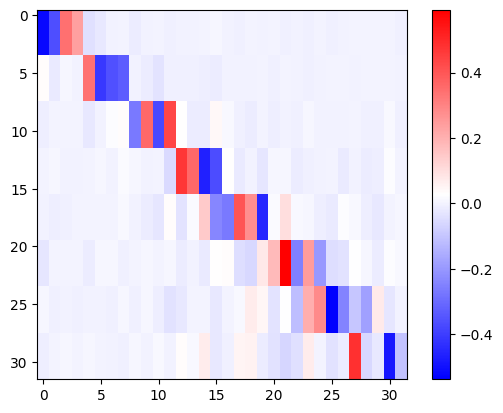

In [12]:
support_mass_norm = torch.nn.functional.normalize(
    supp_vec_1.transpose(1, 2) @ mass_mat,
    p=2, dim=2)

evecs_flip_1_norm = torch.nn.functional.normalize(evecs_flip_1, p=2, dim=1)

# product_with_support = support_vector_norm_repeated.transpose(1, 2) @ mass_mat @ evecs_flip
product_with_support = support_mass_norm @ evecs_flip_1_norm

plt_0 = plt.imshow(product_with_support[0].cpu().numpy(), cmap='bwr')
plt.colorbar(plt_0)

plt.show()

0.84 / 32, max 7

In [8]:
incorrect_signs_per_shape = torch.zeros(len(test_dataset))

for i in range(len(incorrect_signs_list)):
    incorrect_signs_per_shape[i % len(test_dataset)] += incorrect_signs_list[i]

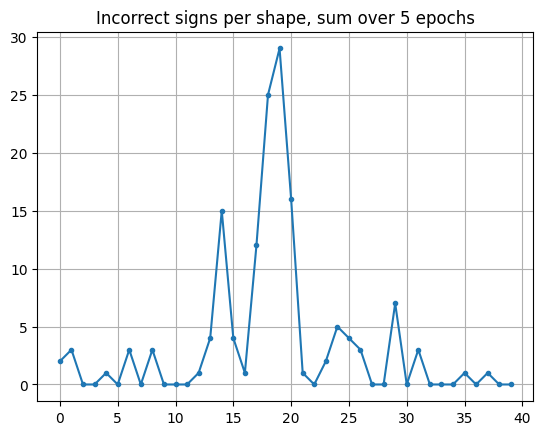

In [24]:
plt.plot(incorrect_signs_per_shape, '.-')
plt.title('Incorrect signs per shape, sum over 5 epochs')
plt.grid()
plt.show()

In [ ]:
scene.geometry.clear()

scene.add_geometry(
    trimesh.creation.axis(
        axis_length=0.5
        )
    )

for i, idx in enumerate([14, 17, 18, 19, 20]):
    mesh_i = trimesh.Trimesh(
        vertices=test_dataset[idx]['second']['verts'] + torch.tensor([i, 0, 0]),
        faces=test_dataset[idx]['second']['faces']
        )
    scene.add_geometry(mesh_i)
    
scene.show()

In [20]:
mesh_19 = trimesh.Trimesh(
    vertices=test_dataset[19]['second']['verts'],
    faces=test_dataset[19]['second']['faces']
    )
mesh_20 = trimesh.Trimesh(
    vertices=test_dataset[20]['second']['verts'],
    faces=test_dataset[20]['second']['faces']
    )

In [21]:
mesh_19.area, mesh_20.area

(1.0000000763350934, 0.9999999140921803)

In [16]:
import my_code.datasets.preprocessing as preprocessing

preprocessing.normalize_face_area(
    test_dataset[20]['second']['verts'],
    test_dataset[20]['second']['faces']
    )

tensor([[-0.0816,  0.2860, -0.0888],
        [-0.0751,  0.2844, -0.0904],
        [-0.0770,  0.2781, -0.0873],
        ...,
        [-0.0206,  0.5229,  0.0490],
        [-0.0242,  0.5256,  0.0515],
        [-0.0244,  0.5273,  0.0545]])

In [17]:
print(test_dataset[20]['second']['verts'])

tensor([[-0.0816,  0.2860, -0.0888],
        [-0.0751,  0.2844, -0.0904],
        [-0.0770,  0.2781, -0.0873],
        ...,
        [-0.0206,  0.5229,  0.0490],
        [-0.0242,  0.5256,  0.0515],
        [-0.0244,  0.5273,  0.0545]])


In [5]:
import torch

t = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).unsqueeze(0)

torch.diag_embed(t).shape

torch.Size([1, 10, 10])

Text(0.5, 1.0, 'Eigenvalues on FAUST orig')

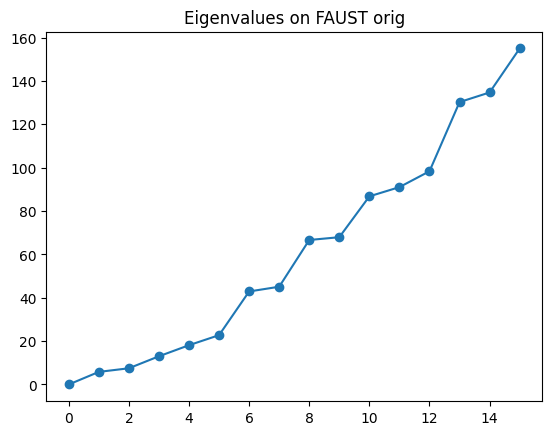

In [17]:
plt.plot(train_dataset[43]['second']['evals'][:16], 'o-')
plt.title('Eigenvalues on FAUST orig')


In [30]:
dataset_orig = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 128, canonicalize_fmap=None
    )[1]
dataset_r = data_loading.get_val_dataset(
    'FAUST_r', 'test', 128, canonicalize_fmap=None
    )[1]
dataset_a = data_loading.get_val_dataset(
    'FAUST_a', 'test', 128, canonicalize_fmap=None
    )[1]

In [31]:
evals_orig = torch.stack([d['second']['evals'][:] for d in dataset_orig])
evals_r = torch.stack([d['second']['evals'][:] for d in dataset_r])
evals_a = torch.stack([d['second']['evals'][:] for d in dataset_a])

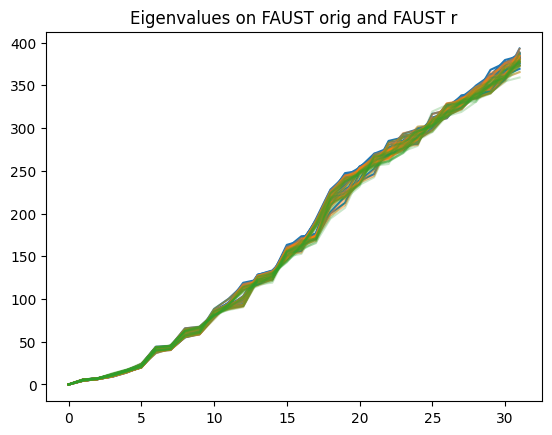

In [40]:
for i in range(len(evals_orig)):
    plt.plot(evals_orig[i][:32], '-', color='tab:blue', alpha=1)
    
for i in range(len(evals_orig)):    
    plt.plot(evals_r[i][:32], '-', color='tab:orange', alpha=0.5)
    
for i in range(len(evals_orig)):    
    plt.plot(evals_a[i][:32], '-', color='tab:green', alpha=0.25)
    
plt.title('Eigenvalues on FAUST orig and FAUST r')
# plt.legend()
plt.show()